In [90]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from keras.src import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
import data_processing as dp

In [91]:
(x_train, y_train), (x_test, y_test) = dp.load_data_keras("../Data")

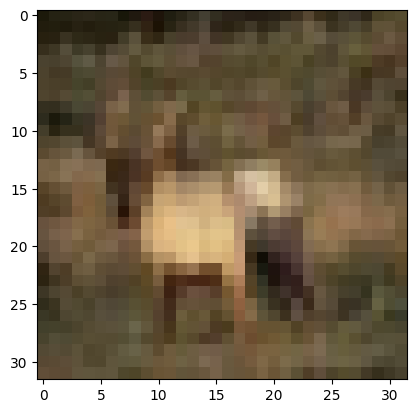

In [92]:
# Check that it's actuall images
plt.imshow(x_train[3])

In [93]:
def rgb2gray(image):
    import cv2
    return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

Xgray_training = [ rgb2gray(x_train[i]) for i in range(len(x_train))]
Xgray_testing  = [ rgb2gray(x_test[i]) for i in range(len(x_test))]

def normalize(image):
    return image/255

Xnor_train = [ normalize(Xgray_training[i]) for i in range(len(Xgray_training))]
Xnor_test  = [ normalize(Xgray_testing[i]) for i in range(len(Xgray_testing))]

In [94]:
# Configuring HOG descriptor
# see http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog

# Configuration of HOG descriptor
normalize = True          #  True ==> yields a little bit better score
                          #  
block_norm = 'L2-Hys'     # or 'L1'
orientations = 9        # 
pixels_per_cell = [8, 8]  #  see section 'Additional remarks' for some explanation
cells_per_block = [2, 2]  # 

def extractFeature(img, vis=False):
    from skimage.feature import hog
    return hog(img, orientations, pixels_per_cell, cells_per_block, block_norm, visualize = vis, transform_sqrt=normalize)

In [95]:
X_training = np.array( [ extractFeature(Xgray_training[i], vis=False) for i in range(len(Xgray_training)) ] )
y_training = np.array( [ y_train[i] for i in range(len(y_train)) ] )

X_testing = np.array( [ extractFeature(Xgray_testing[i], vis=False) for i in range(len(Xgray_testing)) ] )
y_testing = np.array( [ y_test[i] for i in range(len(y_test)) ] )

In [96]:
X_training.shape[1]

324

In [97]:
#set hyperparameters
batch_size = 128
learning_rate = 0.002
num_epochs = 100
n_features = X_training.shape[1]

In [98]:

hog_model = Sequential([
    Input(shape=(n_features,)),
    Flatten(),
    Dense(10, activation='softmax')
])
hog_model.compile(optimizer=Adam(learning_rate=learning_rate), loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
hog_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 324)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,250 (12.70 KB)

 Trainable params: 3,250 (12.70 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
checkpoint = ModelCheckpoint(
    'model/hog_model.keras',             # Path where to save the model
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Save only the best model
    mode='max',                   # Mode for choosing the best value ('max' since higher accuracy is better)
    verbose=1                     # Verbose output to see when checkpoints are saved
)
hog_model.fit(X_training, y_training, epochs=num_epochs, batch_size=batch_size, validation_data=(X_testing, y_testing), callbacks=[checkpoint])

Epoch 1/100
252/391 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.2756 - loss: 2.0984
Epoch 1: val_accuracy improved from -inf to 0.45060, saving model to model/hog_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.3109 - loss: 2.0304 - val_accuracy: 0.4506 - val_loss: 1.6762
Epoch 2/100
382/391 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - accuracy: 0.4544 - loss: 1.6451
Epoch 2: val_accuracy improved from 0.45060 to 0.46500, saving model to model/hog_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - accuracy: 0.4547 - loss: 1.6443 - val_accuracy: 0.4650 - val_loss: 1.5742
Epoch 3/100
386/391 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - accuracy: 0.4764 - loss: 1.5594
Epoch 3: val_accuracy improved from 0.46500 to 0.47770, saving model to model/hog_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - accuracy: 0.4765 - loss: 1.5592 - val_accuracy: 0.4777 - val_loss: 1.5302
Epoch 4/100
245/391 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.4827 - loss: 1.5259
Epoch 4:

In [100]:
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

y_pred = hog_model.predict(X_testing)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_testing, y_pred, target_names=classnames, digits=4))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step
              precision    recall  f1-score   support

    airplane     0.5961    0.5800    0.5879      1000
  automobile     0.5981    0.6190    0.6084      1000
        bird     0.4433    0.3870    0.4132      1000
         cat     0.4365    0.2820    0.3426      1000
        deer     0.4752    0.3920    0.4296      1000
         dog     0.4210    0.4530    0.4364      1000
        frog     0.4677    0.6650    0.5491      1000
       horse     0.5255    0.6080    0.5637      1000
        ship     0.5921    0.5850    0.5885      1000
       truck     0.6289    0.6320    0.6304      1000

    accuracy                         0.5203     10000
   macro avg     0.5184    0.5203    0.5150     10000
weighted avg     0.5184    0.5203    0.5150     10000

